## PAW wavelet clustering

In [1]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
""" 
IMPORTS
"""
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import numpy as np
import pandas as pd
from one.api import ONE
from matplotlib import pyplot as plt
from scipy import stats
from kneed import KneeLocator
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import seaborn as sns

# Get my functions
def idxs_from_files(design_matrices):
    
    idxs = []
    mouse_names = []
    for m, mat in enumerate(design_matrices):
        mouse_name = design_matrices[m][51:]
        eid = design_matrices[m][14:50]
        idx = str(eid + '_' + mouse_name)

        if len(idxs) == 0:
            idxs = idx
            mouse_names = mouse_name
        else:
            idxs = np.hstack((idxs, idx))
            mouse_names = np.hstack((mouse_names, mouse_name))
            
    return idxs, mouse_names

one = ONE(mode='remote')

In [ ]:
""" 
LOAD DATA AND PARAMETERS
"""
# LOAD DATA

data_path = prefix + 'representation_learning_variability/paper-individuality/data/design_matrices/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices)

wavelet_path = prefix + 'representation_learning_variability/paper-individuality/data/paw_wavelets/'
velocity = True

path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'

var = 'paw'

if var == 'paw':
    super_session = np.load(path+'supersession_wavelets_paw09-12-2025')
    wavelet_path = prefix + 'representation_learning_variability/paper-individuality/data/paw_wavelets/'
    states_path = prefix + 'representation_learning_variability/paper-individuality/data/paw_most_likely_states/'

elif var == 'wheel':
    super_session = np.load(path+'supersession_wavelets_wheel09-25-2025')
    wavelet_path = prefix + 'representation_learning_variability/paper-individuality/data/wheel_wavelets/'
    states_path = prefix + 'representation_learning_variability/paper-individuality/data/wheel_most_likely_states/'


In [60]:
var = 'paw'

In [79]:
paws = ['l_paw',  'r_paw']
paw = 'l_paw'

if var == 'paw':
    var_init = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y', 
                    'l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 'l_paw_x16.0', 'l_paw_x32.0',
                    'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0', 'l_paw_y16.0', 'l_paw_y32.0',
                    'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0', 'r_paw_x16.0', 'r_paw_x32.0',
                    'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0', 'r_paw_y16.0', 'r_paw_y32.0']
    var_interest = var_init[4:]
    var_interest = ['l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 
                    'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0', 
                    'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0', 
                    'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0',]
    var_interest = ['l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 'l_paw_x16.0',
                    'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0', 'l_paw_y16.0',
                    'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0', 'r_paw_x16.0',
                    'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0','r_paw_y16.0']
    var_interest = ['l_paw_x0.5','l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 
                    'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0']
    # var_interest = ['l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 
    #                 'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0']
    var_interest = ['l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 
                    'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0', 
                    'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0', 
                    'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0',]
    
    if paw == 'l_paw':
        var_init = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y', 
                        'l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0',
                        'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0',
                        'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0',
                        'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0']
        var_interest = ['l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0', 
                        'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0']
        
    elif paw == 'r_paw':
        var_init = ['l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y', 
                        'l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0',
                        'l_paw_y0.5', 'l_paw_y1.0', 'l_paw_y2.0', 'l_paw_y4.0', 'l_paw_y8.0',
                        'r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0',
                        'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0']
        var_interest = ['r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0', 
                        'r_paw_y0.5', 'r_paw_y1.0', 'r_paw_y2.0', 'r_paw_y4.0', 'r_paw_y8.0']
    
elif var == 'wheel':
    var_init = ['avg_wheel_vel0.5', 'avg_wheel_vel1.0', 'avg_wheel_vel2.0', 'avg_wheel_vel4.0', 'avg_wheel_vel8.0', 
                    'avg_wheel_vel16.0', 'avg_wheel_vel32.0',
                    ]
    var_interest = var_init[:-2]

# Wavelet clustering

In [80]:
df = pd.DataFrame(super_session, columns=var_init)
use_vars = var_interest
use_data = np.array(df[var_interest])
zscore = True

if zscore:
    data = np.array(stats.zscore(use_data, axis=0))
else:
    X_centered = use_data - np.mean(use_data, axis=0)
    data = np.array(use_data)

use_data = data.copy()

# Find best k

### Inertia

In [15]:

inertia_values = []
K = range(1, 60)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cutoff = int(np.shape(use_data)[0]*0.8)
    X_train = np.vstack([use_data[:cutoff, 0], use_data[:cutoff, 1]]).T
    kmeans.fit(X_train.copy())
    inertia_values.append(kmeans.inertia_)
    
kneedle = KneeLocator(K, inertia_values, curve="convex", direction="decreasing")
optimal_k = kneedle.knee
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Elbow at k={optimal_k}')
# Plotting the inertia values
plt.scatter(K, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
# plt.savefig(save_path+'inertia_values_session_part_clusters.svg', format="svg")

plt.show()

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 180, in where
  File "/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/numpy/core/multiarray.py", line 345, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
KeyboardInterrupt: 
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KeyboardInterrupt: 

In [ ]:
print(optimal_k)

8


# kMeans on supersession

In [49]:
# Loop through animals
sessions_to_process = []

for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]

    sessions_to_process.append((mouse_name, session))

In [81]:
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=2024)
kmeans.fit(use_data.copy())
centroids = kmeans.cluster_centers_
cluster_values = kmeans.predict(use_data)

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [82]:
if var == 'paw':
    if velocity:
        subname = "paw_vel_wavelets_"
    else:
        subname = "paw_pos_wavelets_"
    state_name = 'paw_states'
elif var == 'wheel':
    subname = 'wheel_vel_wavelets_'
    state_name = 'wheel_states'
    

In [ ]:

assert len(sessions_to_process) == 218
for m, mat in enumerate(sessions_to_process):

    mouse_name = mat[0]
    session = mat[1]
    filename = wavelet_path + subname + str(session) + '_'  + mouse_name
    design_matrix = pd.read_parquet(filename)

    var_array = np.array(design_matrix[use_vars].copy())
    not_nan = ~np.isnan(var_array).any(axis=1)
    mouse_data = stats.zscore(var_array[not_nan, :], axis=0, nan_policy='omit')
        
    """ Compute clusters based on supersession centroids """
    # Compute distances between full dataset and trained centroids
    distances = cdist(mouse_data, centroids, metric='euclidean')
    # Assign each point to the nearest centroid
    states = np.argmin(distances, axis=1)
    
    design_matrix[state_name] = np.nan
    design_matrix[state_name][not_nan] = states
    
    # """ Save paw states on design_matrix """
    # # Save most_likely_states
    # filename = states_path + "most_likely_states" + '_'+str(optimal_k)+'_'+ str(mouse_name+session)
    # np.save(filename, states)
    # # Save most_likely_states
    # filename = states_path + "centroid_distances" + '_'+str(optimal_k)+'_'+ str(mouse_name+session)
    # np.save(filename, distances)


/tmp/ipykernel_22265/1840402778.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[state_name][not_nan] = states
/tmp/ipykernel_22265/1840402778.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

KeyboardInterrupt: 

# Visualize cluster statistics

In [99]:
optimal_k = 3

In [100]:
all_data = pd.DataFrame(use_data, columns=use_vars)
kmeans = KMeans(n_clusters=optimal_k, random_state=2024)
kmeans.fit(use_data.copy())
centroids = kmeans.cluster_centers_
all_data[state_name] = kmeans.predict(use_data)
wavelet_df = pd.melt(all_data, id_vars=[state_name], value_vars=use_vars)

/opt/anaconda3/envs/iblenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [101]:
palette = sns.color_palette('Set1', optimal_k)

# Wheel wavelets

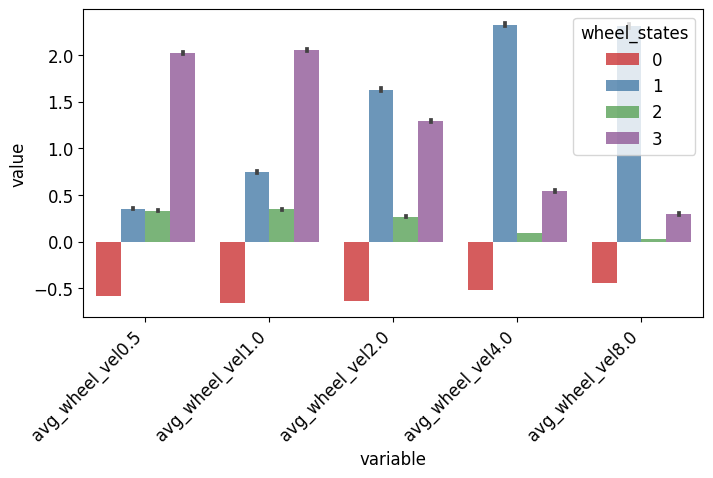

In [27]:
variables = ['avg_wheel_vel0.5', 'avg_wheel_vel1.0', 'avg_wheel_vel2.0', 'avg_wheel_vel4.0', 'avg_wheel_vel8.0']


fig, ax = plt.subplots(figsize=[8, 4])
plt.rc('font', size=12)

sns.barplot(hue=state_name, y='value', x='variable', ax=ax,
                data=wavelet_df.loc[wavelet_df['variable'].isin(variables)], palette=palette, alpha=.8)
plt.xticks(rotation=45, ha='right')
plt.show()

In [28]:
palette = sns.color_palette('Set1', n_colors=optimal_k, as_cmap=True)

assert len(sessions_to_process) == 218
for m, mat in enumerate(sessions_to_process[:10]):

    mouse_name = mat[0]
    session = mat[1]
    filename = wavelet_path + subname + str(session) + '_'  + mouse_name
    design_matrix = pd.read_parquet(filename)

    # Prepare data
    # data_df = design_matrix[var_interest].copy().dropna()
    # data = np.array(data_df)

    var_array = np.array(design_matrix[use_vars].copy())
    not_nan = ~np.isnan(var_array).any(axis=1)
    mouse_data = stats.zscore(var_array[not_nan, :], axis=0, nan_policy='omit')
        
    """ Compute clusters based on supersession centroids """
    # Compute distances between full dataset and trained centroids
    distances = cdist(mouse_data, centroids, metric='euclidean')
    # Assign each point to the nearest centroid
    states = np.argmin(distances, axis=1)
    # replace_func = np.vectorize(paw_mapping.get)
    # new_states = replace_func(states)
    new_states = states
    design_matrix[state_name] = np.nan
    design_matrix[state_name][not_nan] = new_states
    
    fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 5])
    plt.rc('font', size=12)
    init = 000
    ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'avg_wheel_vel'].reset_index()['avg_wheel_vel'], nan_policy='omit'), color='black', label='wheel')
    ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'l_paw_x'].reset_index()['l_paw_x'], nan_policy='omit'), alpha=.5, color='green', label='left x')
    ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'l_paw_y'].reset_index()['l_paw_y'], nan_policy='omit'), alpha=.5, linestyle='--', color='green', label='left y')
    ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'r_paw_x'].reset_index()['r_paw_x'], nan_policy='omit'), alpha=.5, color='red', label='right x')
    ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'r_paw_y'].reset_index()['r_paw_y'], nan_policy='omit'), alpha=.5, linestyle='--',color='red', label='right y')
    attach_array = np.arange(0, optimal_k, 1)
    ax.imshow(np.concatenate([design_matrix.loc[design_matrix['Bin']>=init, state_name]])[None,:],
                extent=(0, len(np.concatenate([design_matrix.loc[design_matrix['Bin']>=init, state_name]])), -10, 10),
                aspect="auto",
                alpha=0.6,
                cmap=palette)  # 
    init=8000
    plt.xlim([init, init+1000])
    plt.ylim([-5, 5])
    plt.legend()
    plt.show()
    # plt.hist(states)
    # plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/paper-individuality/data/wheel_wavelets/wheel_vel_wavelets_0f77ca5d-73c2-45bd-aa4c-4c5ed275dbde_NR_0027'

# Paw wavelets

In [86]:
fix_mapping = {0: 4,
        1:1,
        2:5,
        3:7,
        4:6,
        5:2,
        6:0,
        7:3
        }

replace_func = np.vectorize(fix_mapping.get)
wavelet_df['Paw syllables'] = replace_func(wavelet_df['paw_states'])

In [87]:
palette=sns.color_palette('Set2', 8)

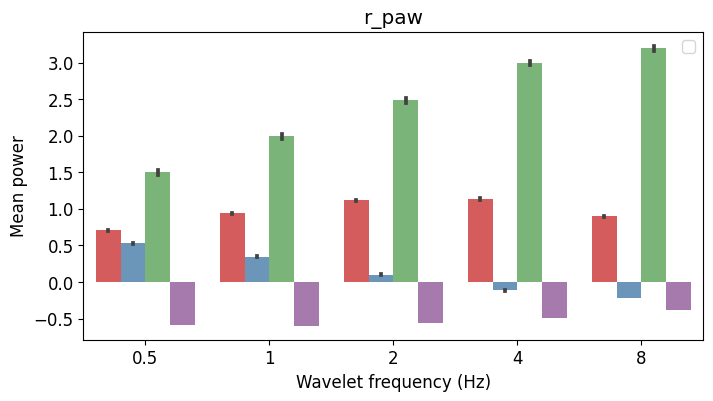

In [ ]:
x_right = ['r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0']

fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=True, figsize=[8, 4])
plt.rc('font', size=12)
use_states = 'paw_states'
sns.barplot(hue=use_states, y='value', x='variable', ax=ax,
                data=wavelet_df.loc[wavelet_df['variable'].isin(x_right)], palette=palette, alpha=.8)
ax.set_xlabel('Wavelet frequency (Hz)')
ax.set_ylabel('Mean power')
ax.set_title(paw)
ax.set_xticks([0, 1, 2, 3, 4], [0.5, 1, 2, 4, 8])
ax.legend('')
plt.show()

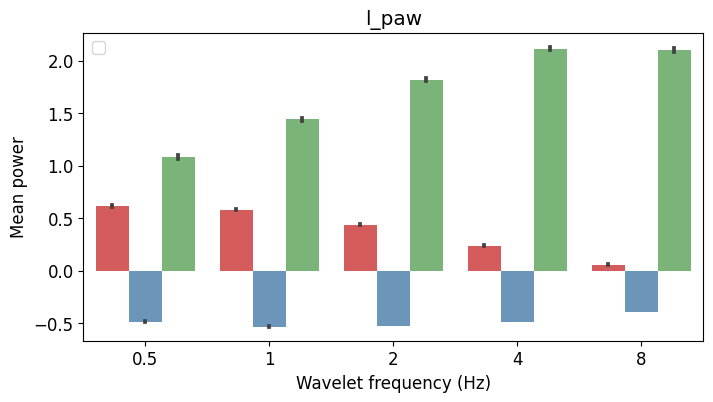

In [102]:
x_left = ['l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0']

fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=True, figsize=[8, 4])
plt.rc('font', size=12)
use_states = 'paw_states'
sns.barplot(hue=use_states, y='value', x='variable', ax=ax,
                data=wavelet_df.loc[wavelet_df['variable'].isin(x_left)], palette=palette, alpha=.8)

ax.set_xlabel('Wavelet frequency (Hz)')
ax.set_title(paw)
ax.set_ylabel('Mean power')
ax.set_xticks([0, 1, 2, 3, 4], [0.5, 1, 2, 4, 8])
ax.legend('')
plt.show()

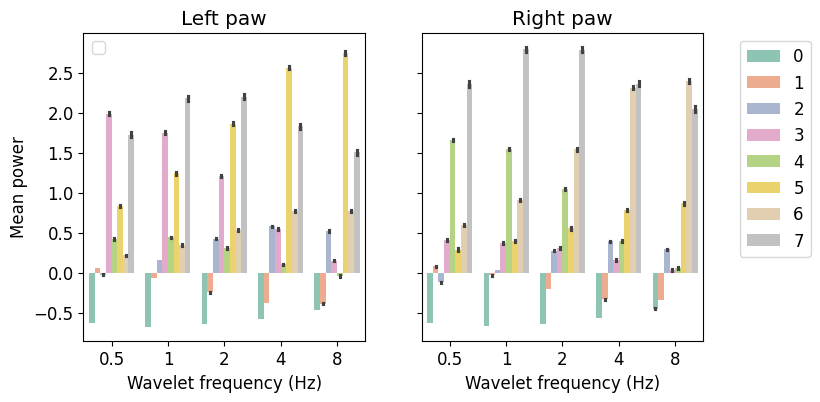

In [65]:
x_left = ['l_paw_x0.5', 'l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0']
x_right = ['r_paw_x0.5', 'r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0']

fig, ax = plt.subplots(ncols=2 , nrows=1, sharex=False, sharey=True, figsize=[8, 4])
plt.rc('font', size=12)
use_states = 'Paw syllables'
sns.barplot(hue=use_states, y='value', x='variable', ax=ax[0],
                data=wavelet_df.loc[wavelet_df['variable'].isin(x_left)], palette=palette, alpha=.8)
ax[0].set_title('Left paw')
sns.barplot(hue=use_states, y='value', x='variable', ax=ax[1],
                data=wavelet_df.loc[wavelet_df['variable'].isin(x_right)], palette=palette, alpha=.8)
ax[0].set_xlabel('Wavelet frequency (Hz)')
ax[1].set_xlabel('Wavelet frequency (Hz)')
ax[1].set_title('Right paw')
ax[0].set_ylabel('Mean power')
ax[0].set_xticks([0, 1, 2, 3, 4], [0.5, 1, 2, 4, 8])
ax[1].set_xticks([0, 1, 2, 3, 4], [0.5, 1, 2, 4, 8])
ax[0].legend('')
ax[1].legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.show()

In [98]:
paw_mapping = {0:1, 1:2, 2:4, 3:0, 4:3}  # 

In [68]:
paw_mapping = {0:0, 1:3, 2:2, 3:1}  # 

In [29]:
paw_mapping = {0:1, 1:5, 2:3, 3:0, 4:6, 5:4, 6:7, 7:2}  # original
paw_mapping = {0:0, 1:2, 2:1, 3:0, 4:2, 5:1, 6:2, 7:1}  # low medium high
paw_mapping = {0:0, 1:3, 2:2, 3:0, 4:4, 5:1, 6:5, 7:1}  # 


paw_mapping = {0:4, 1:1, 2:5, 3:7, 4:6, 5:2, 6:0, 7:3}  # 

/tmp/ipykernel_3447/1554252269.py:31: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix['paw_states'][not_nan] = new_states
/tmp/ipykernel_3447/1554252269.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

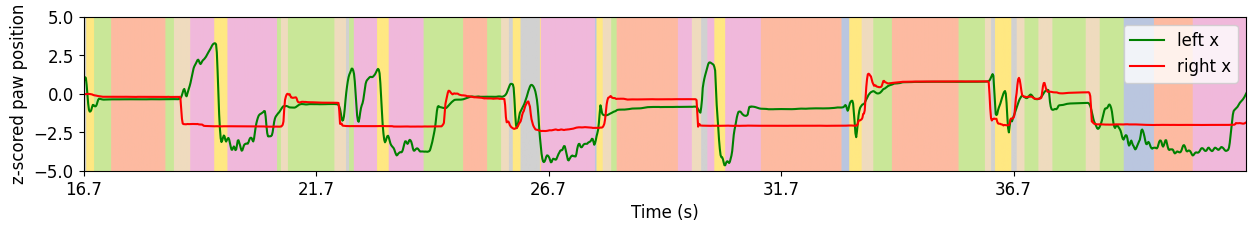

In [34]:
palette = sns.color_palette('Set2', n_colors=optimal_k, as_cmap=True)
if velocity:
    subname = "paw_vel_wavelets_"
else:
    subname = "paw_pos_wavelets_"
assert len(sessions_to_process) == 218
for m, mat in enumerate(sessions_to_process[95:96]):

    mouse_name = mat[0]
    session = mat[1]
    filename = wavelet_path + subname + str(session) + '_'  + mouse_name
    design_matrix = pd.read_parquet(filename)

    # Prepare data
    # data_df = design_matrix[var_interest].copy().dropna()
    # data = np.array(data_df)

    var_array = np.array(design_matrix[use_vars].copy())
    not_nan = ~np.isnan(var_array).any(axis=1)
    mouse_data = stats.zscore(var_array[not_nan, :], axis=0, nan_policy='omit')
        
    """ Compute clusters based on supersession centroids """
    # Compute distances between full dataset and trained centroids
    distances = cdist(mouse_data, centroids, metric='euclidean')
    # Assign each point to the nearest centroid
    states = np.argmin(distances, axis=1)
    replace_func = np.vectorize(paw_mapping.get)
    new_states = replace_func(states)
    # new_states = states
    design_matrix['paw_states'] = np.nan
    design_matrix['paw_states'][not_nan] = new_states
    
    fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[15, 2])
    plt.rc('font', size=12)
    init = 1000
    # ax.plot(design_matrix.loc[design_matrix['Bin']>=init, 'avg_wheel_vel'].reset_index(), color='black')
    ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'l_paw_x'].reset_index()['l_paw_x'], nan_policy='omit'), color='green', label='left x')
    # ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'l_paw_y'].reset_index()['l_paw_y'], nan_policy='omit'), linestyle='--', color='green', label='left y')
    ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'r_paw_x'].reset_index()['r_paw_x'], nan_policy='omit'), color='red', label='right x')
    # ax.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'r_paw_y'].reset_index()['r_paw_y'], nan_policy='omit'), linestyle='--',color='red', label='right y')
    attach_array = np.arange(0, optimal_k, 1)
    ax.imshow(np.concatenate([design_matrix.loc[design_matrix['Bin']>=init, 'paw_states'].reset_index()['paw_states']])[None,:],
                extent=(0, len(np.concatenate([design_matrix.loc[design_matrix['Bin']>=init, 'paw_states'].reset_index()['paw_states']])), -10, 10),
                aspect="auto",
                alpha=0.6,
                cmap=palette)  # 
    init=1000
    plt.xlim([init, init+1500])
    plt.ylabel('z-scored paw position')
    plt.xlabel('Time (s)')
    plt.ylim([-5, 5])
    inter = 1500
    frame_rate = 60
    plt.xticks(np.arange(init, init+inter, inter/5), np.round(np.arange(init/frame_rate, 
                  (init+inter)/frame_rate, (inter/frame_rate)/5), 1))
    # plt.xticks([2000, 2200, 2400, 2600, 2800, 3000], np.round(0.017*np.array([2000, 2200, 2400, 2600, 2800, 3000]), 2))
    plt.legend()
    plt.show()
    # plt.hist(states)
    # plt.show()

(1000.0, 2500.0)

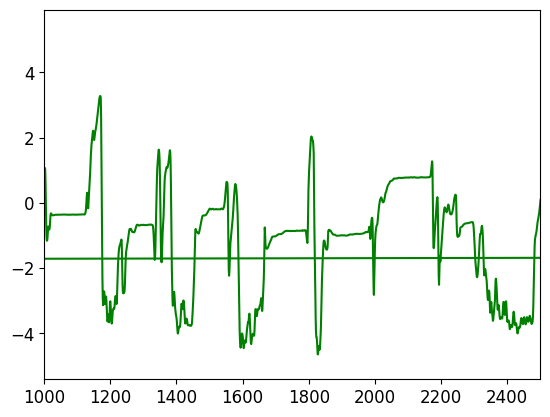

In [31]:
init = 1000
plt.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'l_paw_x'].reset_index()['l_paw_x'], nan_policy='omit'), color='green', label='left x')
plt.plot(stats.zscore(design_matrix.loc[design_matrix['Bin']>=init, 'Bin'].reset_index()['Bin'], nan_policy='omit'), color='green', label='left x')
plt.xlim([init, init+1500])

# plt.xlim([])